## **ARIMA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:


url = 'https://docs.google.com/spreadsheets/d/1Q1oZ7W2_-ZScZ211nSqinzFHrZseVMPfvjGm-HJUJLo/edit#gid=1699840261'

# Modify the URL
csv_url = url.replace('/edit#gid=', '/gviz/tq?tqx=out:csv&gid=')

# Read into a DataFrame
data = pd.read_csv(csv_url)

In [ ]:
data

,date,pm25,pm10,o3,no2,co,AQI
0,2015/7/10,NaN,64.0,13.0,21.0,29.0,64
1,2015/7/11,NaN,64.0,13.0,21.0,29.0,64
2,2015/8/24,72.0,134.0,14.0,NaN,4.0,134
3,2015/8/25,55.0,94.0,15.0,NaN,10.0,94
4,2015/8/26,54.0,57.0,25.0,18.0,22.0,57
...,...,...,...,...,...,...,...
2209,2021/11/11,99.0,105.0,75.0,31.0,51.0,105
2210,2021/11/12,110.0,104.0,75.0,30.0,51.0,110
2211,2021/11/13,110.0,102.0,71.0,33.0,51.0,110
2212,2021/11/14,104.0,102.0,67.0,33.0,NaN,104


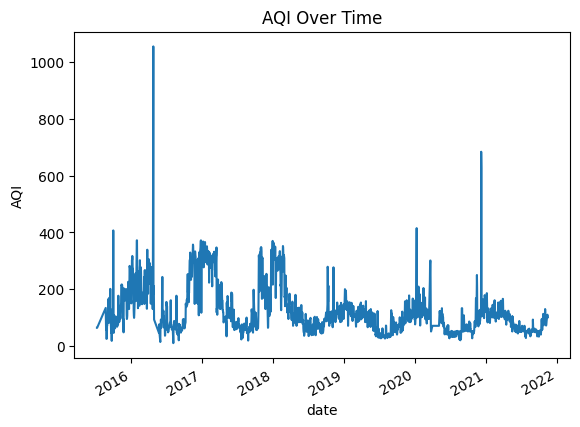

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Plot AQI
data['AQI'].plot()
plt.title('AQI Over Time')
plt.ylabel('AQI')
plt.show()


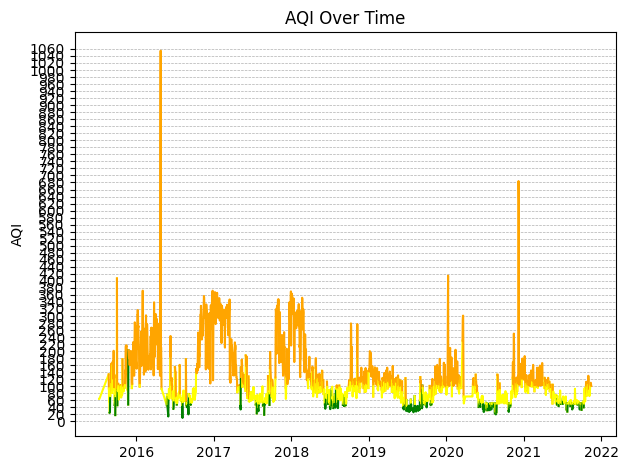

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Determine segments of data based on AQI values
segments = []

start = data.index[0]
current_color = None

for date, aqi in data['AQI'].items():
    if aqi <= 50:
        color = 'green'
    elif aqi <= 100:
        color = 'yellow'
    else:
        color = 'orange'

    if current_color is None:
        current_color = color
    elif current_color != color:
        segments.append((start, date, current_color))
        start = date
        current_color = color

segments.append((start, date, current_color))

# Plot segments
for start, end, color in segments:
    subset = data[start:end]
    plt.plot(subset.index, subset['AQI'], color=color)

# Setting y-ticks to represent actual values in increments of 20
plt.yticks(list(range(0, int(data['AQI'].max()) + 20, 20)))

plt.title('AQI Over Time')
plt.ylabel('AQI')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(data['AQI'])


Results of Dickey-Fuller Test:
Test Statistic                   -3.254182
p-value                           0.017055
#Lags Used                       18.000000
Number of Observations Used    2195.000000
Critical Value (1%)              -3.433333
Critical Value (5%)              -2.862858
Critical Value (10%)             -2.567471
dtype: float64


In [ ]:
data['AQI_diff'] = data['AQI'] - data['AQI'].shift(1)
data.dropna(inplace=True)

test_stationarity(data['AQI_diff'])


Results of Dickey-Fuller Test:
Test Statistic                -1.810621e+01
p-value                        2.545171e-30
#Lags Used                     6.000000e+00
Number of Observations Used    1.639000e+03
Critical Value (1%)           -3.434346e+00
Critical Value (5%)           -2.863305e+00
Critical Value (10%)          -2.567710e+00
dtype: float64


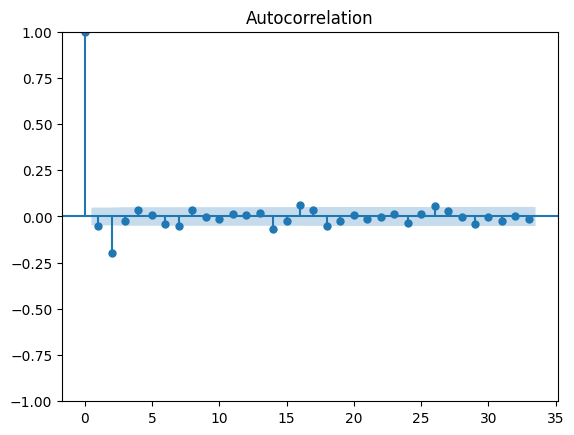

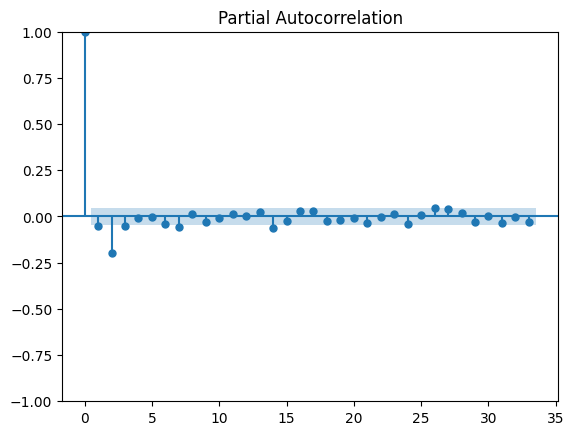

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data['AQI_diff'])
plot_pacf(data['AQI_diff'])
plt.show()


In [ ]:
pip install statsmodels

In [ ]:
# frequency of the dataframe is set to monthly
data = data.asfreq('M')

# Train ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Replace these with optimal values
p, d, q = 1, 1, 1

model = ARIMA(data['AQI'], order=(p,d,q))
model_fit = model.fit()


In [ ]:
forecast = model_fit.forecast(steps=12)  # Forecasting for the next 12 months
print(forecast)


2021-11-30    104.223512
2021-12-31    100.171282
2022-01-31     97.328626
2022-02-28     95.334491
2022-03-31     93.935597
2022-04-30     92.954267
2022-05-31     92.265860
2022-06-30     91.782940
2022-07-31     91.444169
2022-08-31     91.206520
2022-09-30     91.039809
2022-10-31     90.922860
Freq: M, Name: predicted_mean, dtype: float64


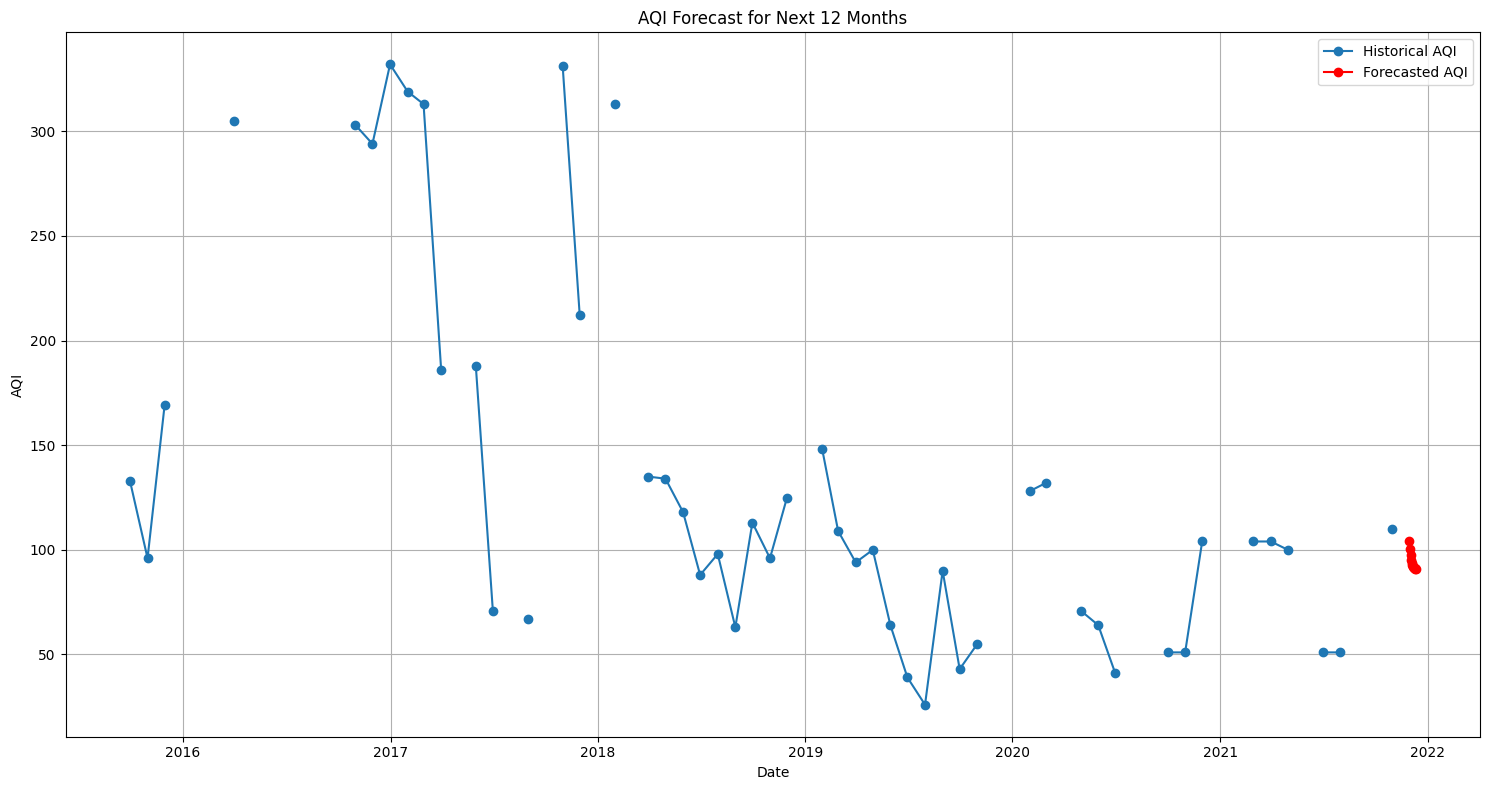

In [ ]:
plt.figure(figsize=(15,8))

# Plot historical AQI values
plt.plot(data.index, data['AQI'], label='Historical AQI', linestyle='-', marker='o')

# Generating the next 12 months after the last date in your data
forecast_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=12)

# Plot forecasted AQI values
plt.plot(forecast_dates, forecast, label='Forecasted AQI', color='red', linestyle='-', marker='o')

plt.legend()
plt.title('AQI Forecast for Next 12 Months')
plt.ylabel('AQI')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
model_daily = ARIMA(data['AQI'], order=(p,d,q))
model_fit_daily = model_daily.fit()

forecast_daily = model_fit_daily.forecast(steps=365)


In [ ]:
average_forecasted_AQI = sum(forecast_daily) / len(forecast_daily)

# or using numpy:

import numpy as np
average_forecasted_AQI = np.mean(forecast_daily)

print("The average predicted AQI for the next year is:", average_forecasted_AQI)

The average predicted AQI for the next year is: 90.77261616050485


In [ ]:
actual = 101  # Replace with  actual value
forecast = 90  # Replace with  forecasted value

mae = abs(actual - forecast)
print(f"MAE: {mae}")

percentage_error = (mae / actual) * 100
accuracy = 100 - percentage_error
print(f"Model Accuracy: {accuracy:.2f}%")



MAE: 11
Model Accuracy: 89.11%


## **LSTM**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM


In [ ]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [ ]:
look_back = 1
X, Y = [], []

for i in range(len(scaled_data) - look_back - 1):
    X.append(scaled_data[i:(i + look_back), :-1])
    Y.append(scaled_data[i + look_back, -1])

X, Y = np.array(X), np.array(Y)


In [ ]:
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]


In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, Y_train, epochs=50, batch_size=1, validation_data=(X_test, Y_test))


Epoch 1/50
1482/1482 [==============================] - 4s 2ms/step - loss: nan - val_loss: nan
Epoch 2/50
1482/1482 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 3/50
1482/1482 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 4/50
1482/1482 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 5/50
1482/1482 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 6/50
1482/1482 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 7/50
1482/1482 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 8/50
1482/1482 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 9/50
1482/1482 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 10/50
1482/1482 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 11/50
1482/1482 [================

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


23/23 [==============================] - 0s 1ms/step


In [ ]:
# Create dummy array with same shape as original scaled_data
dummy = np.zeros((len(train_predict), scaled_data.shape[1] - 1))

# Combine the dummy array with train_predict to form a complete dataset shape
train_combined = np.hstack((dummy, train_predict))

# Now inverse transform this combined data
train_predict_original = scaler.inverse_transform(train_combined)[:, -1]

# Similarly for test data:
dummy_test = np.zeros((len(test_predict), scaled_data.shape[1] - 1))
test_combined = np.hstack((dummy_test, test_predict))
test_predict_original = scaler.inverse_transform(test_combined)[:, -1]



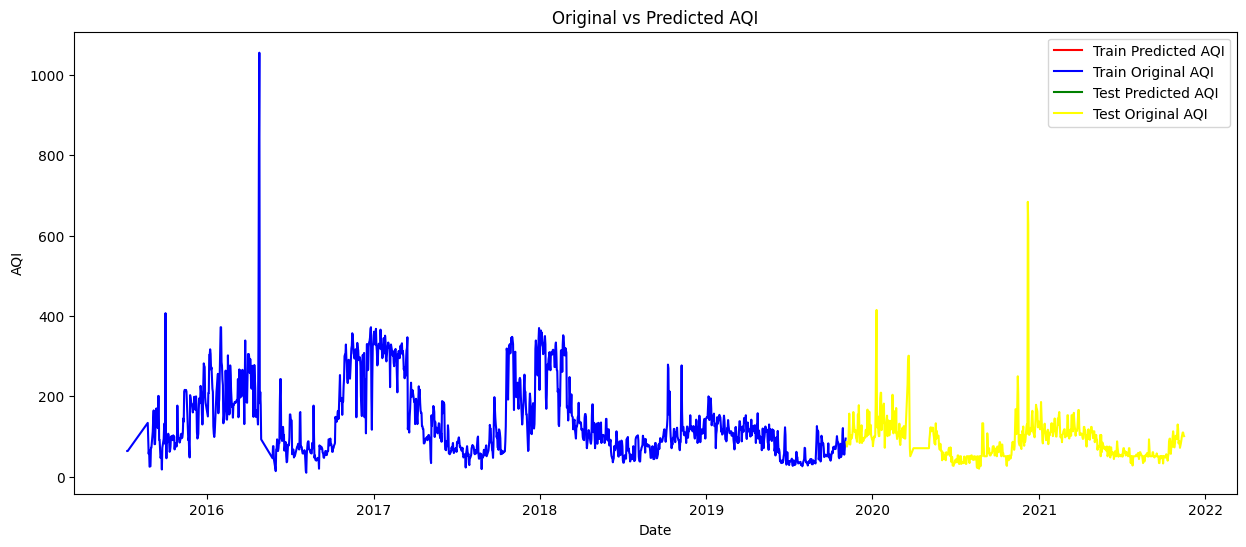

In [ ]:
plt.figure(figsize=(15, 6))

# Train original and predicted
plt.plot(data.index[1:train_size + 1], train_predict_original, color='red', label='Train Predicted AQI')

plt.plot(data.index[:train_size], data['AQI'].iloc[:train_size], color='blue', label='Train Original AQI')

# Test original and predicted
plt.plot(data.index[train_size + 2:], test_predict_original, color='green', label='Test Predicted AQI')

plt.plot(data.index[train_size + 1:], data['AQI'].iloc[train_size + 1:], color='yellow', label='Test Original AQI')

plt.title('Original vs Predicted AQI')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [ ]:
print(data.isna().sum())


pm25     89
pm10     72
o3       46
no2     216
co      414
AQI       0
dtype: int64


Epoch 1/50
1482/1482 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 2/50
1482/1482 [==============================] - 5s 4ms/step - loss: nan - val_loss: nan
Epoch 3/50
1482/1482 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 4/50
1482/1482 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 5/50
1482/1482 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 6/50
1482/1482 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 7/50
1482/1482 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 8/50
1482/1482 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 9/50
1482/1482 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 10/50
1482/1482 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 11/50
1482/1482 [================

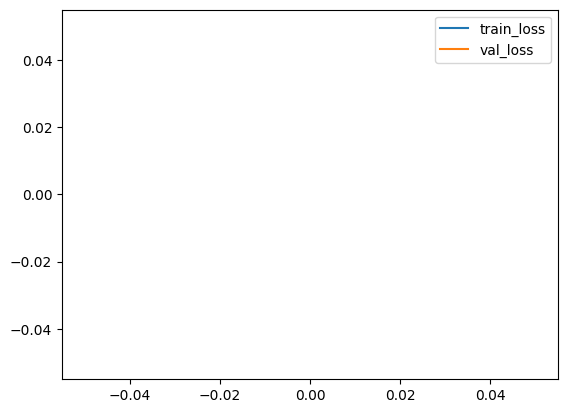

In [ ]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=1, validation_data=(X_test, Y_test))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


## **SARIMA**

In [ ]:
import pandas as pd

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)


In [ ]:
train = data[:-30]  # Use all data except the last month for training
test = data[-30:]   # Use the last month for testing


In [ ]:
!pip install statsmodels

In [ ]:
pip install pmdarima


In [ ]:
from pmdarima import auto_arima

model = auto_arima(train['AQI'], seasonal=True, m=30, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True)

model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=22171.239, Time=55.87 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=22527.549, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=22525.552, Time=1.46 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=22518.838, Time=2.06 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=22525.549, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=22169.370, Time=12.11 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=22168.464, Time=1.08 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=22169.356, Time=13.70 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=22167.543, Time=0.91 sec
 ARIMA(1,1,2)(1,0,0)[30] intercept   : AIC=22168.334, Time=9.52 sec
 ARIMA(1,1,2)(0,0,1)[30] intercept   : AIC=22168.349, Time=10.06 sec
 ARIMA(1,1,2)(1,0,1)[30] intercept   : AIC=22170.214, Time=18.44 sec
 ARIMA(0,1,2)(0,0,0)[30] intercept   : AIC=22235.147, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=22243.741, Time=0.52 sec


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2184
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -11078.773
Date:                Tue, 10 Oct 2023   AIC                          22165.545
Time:                        13:05:25   BIC                          22188.299
Sample:                             0   HQIC                         22173.863
                               - 2184                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3883      0.017     22.958      0.000       0.355       0.421
ma.L1         -0.5607      0.020    -28.587      0.000      -0.599      -0.522
ma.L2         -0.2984      0.010    -31.386      0.000      -0.317      -0.280
sigma2      1497.9024      8.893    168.437      0.000    1480.473    1515.332
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            475558.93
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        75.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


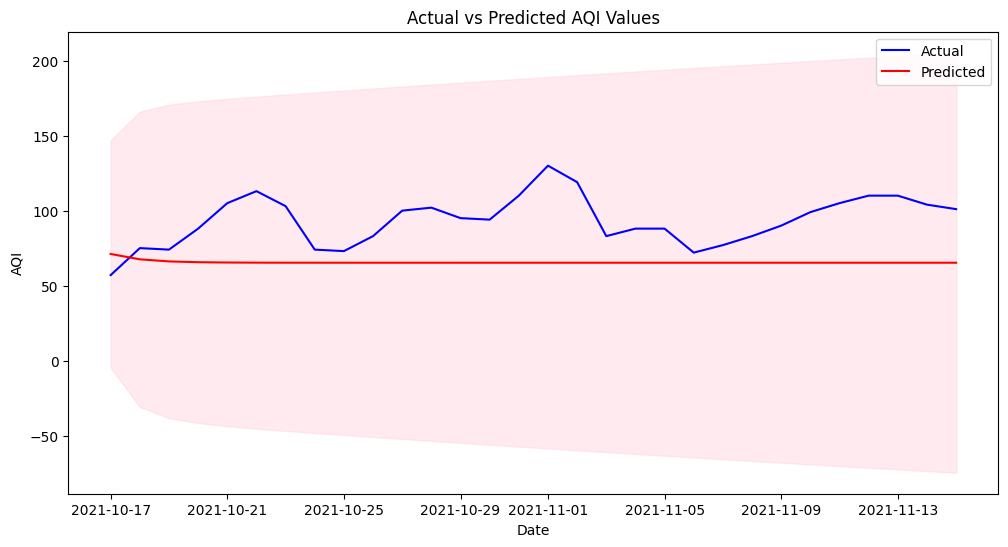

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['AQI'], label='Actual', color='blue')
plt.plot(test.index, forecast, label='Predicted', color='red')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('Actual vs Predicted AQI Values')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [ ]:
forecast_df = pd.DataFrame({'Date': test.index, 'Predicted_AQI': forecast})
print(forecast_df)


           Date  Predicted_AQI
2184 2021-10-17      71.096780
2185 2021-10-18      67.524537
2186 2021-10-19      66.137404
2187 2021-10-20      65.598768
2188 2021-10-21      65.389611
2189 2021-10-22      65.308393
2190 2021-10-23      65.276856
2191 2021-10-24      65.264609
2192 2021-10-25      65.259854
2193 2021-10-26      65.258008
2194 2021-10-27      65.257291
2195 2021-10-28      65.257012
2196 2021-10-29      65.256904
2197 2021-10-30      65.256862
2198 2021-10-31      65.256846
2199 2021-11-01      65.256839
2200 2021-11-02      65.256837
2201 2021-11-03      65.256836
2202 2021-11-04      65.256836
2203 2021-11-05      65.256835
2204 2021-11-06      65.256835
2205 2021-11-07      65.256835
2206 2021-11-08      65.256835
2207 2021-11-09      65.256835
2208 2021-11-10      65.256835
2209 2021-11-11      65.256835
2210 2021-11-12      65.256835
2211 2021-11-13      65.256835
2212 2021-11-14      65.256835
2213 2021-11-15      65.256835


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['AQI'], forecast)
mse = mean_squared_error(test['AQI'], forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test['AQI'] - forecast) / test['AQI'])) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Absolute Error (MAE): 28.864709636355016
Mean Squared Error (MSE): 1061.5328395794047
Root Mean Squared Error (RMSE): 32.581173084764835
Mean Absolute Percentage Error (MAPE): nan%


<ipython-input-18-1096c3d09ca5>:7: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test['AQI'] - forecast) / test['AQI'])) * 100


In [ ]:
epsilon = 1e-10
mape = np.mean(np.abs((test['AQI'] - forecast) / (test['AQI'] + epsilon))) * 100


<ipython-input-20-27c90b6c2b50>:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test['AQI'] - forecast) / (test['AQI'] + epsilon))) * 100


In [ ]:
import numpy as np

mape = np.mean(np.abs((test['AQI'] - forecast) / test['AQI'])) * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Percentage Error (MAPE): nan%


<ipython-input-21-2295b251a64b>:3: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test['AQI'] - forecast) / test['AQI'])) * 100


In [ ]:
forecast_series = pd.Series(forecast, index=test.index)
mape = np.mean(np.abs((test['AQI'] - forecast_series) / (test['AQI'] + epsilon))) * 100


In [ ]:
import numpy as np

# Calculate the Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test['AQI'] - forecast) / test['AQI'])) * 100

# Display the MAPE as a percentage
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Percentage Error (MAPE): nan%


<ipython-input-23-cbf9f3e4e644>:4: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test['AQI'] - forecast) / test['AQI'])) * 100


In [ ]:
# Ensure both forecast and test['AQI'] are of the same length and are properly aligned
assert len(test['AQI']) == len(forecast), "Length mismatch between test and forecast."

# Convert forecast to a pandas series with the same index as test['AQI']
forecast_series = pd.Series(forecast, index=test.index)

# Calculate MAPE, adding a small constant epsilon to avoid division by zero and dropna to handle NaNs
epsilon = 1e-10
mape = np.mean(np.abs((test['AQI'] - forecast_series) / (test['AQI'] + epsilon)).dropna()) * 100

# Display the MAPE as a percentage
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Percentage Error (MAPE): nan%


In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test['AQI'], forecast)
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Mean Absolute Error (MAE): 28.86


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test['AQI'], forecast))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Root Mean Squared Error (RMSE): 32.58


In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(test['AQI'], forecast)
print(f"R-squared (R2): {r2:.2f}")


R-squared (R2): -3.05


An \( R^2 \) value of \(-3.05\) is not a good sign. The \( R^2 \) value can theoretically range from \(-\infty\) to \(1\), but in common cases, it typically falls between 0 and 1. A negative \( R^2 \) value indicates that the model fits the data worse than a horizontal line (the mean). In other words, the model's predictions are, on average, worse than if you had simply predicted the mean of the target variable for all instances.

Several factors could lead to a negative \( R^2 \):

1. **Model is not suitable**: The SARIMA model might not be suitable for your dataset. The data might have characteristics or patterns that SARIMA can't capture well.

2. **Outliers**: The presence of outliers in your dataset can significantly impact the model's performance, leading to a poor fit.

3. **Overfitting**: The model might be overfitting to the training data, which means it's capturing noise rather than the underlying patterns. This can result in poor generalization to the test data.

4. **Wrong hyperparameters**: The SARIMA model's parameters might not be optimal. If you relied on automated methods like `auto_arima`, it might not have chosen the best parameters.

5. **Seasonality and Trend**: The chosen seasonality (e.g., `m=365` in `auto_arima`) might not be appropriate, or there might be other underlying trends in the data that the model hasn't captured.

6. **Insufficient data**: If the training data doesn't capture enough variability or cycles in the data, the model might not generalize well to the test set.

**Possible Solutions:**

1. **Revisit the model's assumptions**: Check if SARIMA is the right model for your data. Plot your data to visually inspect its characteristics.

2. **Handle outliers**: Investigate your dataset for outliers and consider strategies to manage them.

3. **Try different models**: Experiment with other time series models or machine learning regression models.

4. **Parameter tuning**: If you're committed to SARIMA, consider manually tuning the hyperparameters or using a more exhaustive search strategy than `auto_arima`.

5. **Additional Features**: If there are other external factors that influence AQI that aren't captured in your dataset, consider adding them.

6. **Model Evaluation**: Consider using a rolling forecast origin or walk-forward validation approach to get a more accurate sense of the model's out-of-sample performance.

7. **Increase Data**: If possible, collect more data. More historical data might help the model understand the underlying patterns better.

Remember, a single metric (like \( R^2 \)) does not tell the whole story. Always consider multiple metrics, visual inspections, and domain knowledge when evaluating model performance.

## **FACEBOOK PROPHET**

In [ ]:
!pip install fbprophet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 911.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
Failed to build fbprophet
ERROR: Could not build wheels for fbprophet, which is required to install pyproject.toml-based projects


In [ ]:
import pandas as pd
from prophet import Prophet



In [ ]:

df = data[['date', 'AQI']]
df.columns = ['ds', 'y']


In [ ]:
model = Prophet(daily_seasonality=True)
model.fit(df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmphjs7oy51/2w42vjv_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphjs7oy51/ai9fwwnp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73279', 'data', 'file=/tmp/tmphjs7oy51/2w42vjv_.json', 'init=/tmp/tmphjs7oy51/ai9fwwnp.json', 'output', 'file=/tmp/tmphjs7oy51/prophet_modelzdpmmux2/prophet_model-20231011092740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:27:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:27:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)


In [ ]:
predicted_aqi = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)
print(predicted_aqi)


             ds        yhat  yhat_lower  yhat_upper
2214 2021-11-16  136.479306   63.680688  206.988086
2215 2021-11-17  138.010094   67.951097  218.139477
2216 2021-11-18  138.064121   61.220369  204.896163
2217 2021-11-19  141.010030   64.683276  209.102912
2218 2021-11-20  139.876872   72.136451  211.652494
2219 2021-11-21  137.490773   60.755065  208.870544
2220 2021-11-22  139.937002   68.748026  214.579408
2221 2021-11-23  134.180731   67.954833  208.234283
2222 2021-11-24  134.540436   65.980859  205.798091
2223 2021-11-25  133.493294   59.536106  201.705794
2224 2021-11-26  135.430026   62.505515  209.362659
2225 2021-11-27  133.401842   61.928441  212.211465
2226 2021-11-28  130.256551   63.426885  202.562339
2227 2021-11-29  132.100051   61.057452  206.895207
2228 2021-11-30  125.916507   58.873110  197.051808
2229 2021-12-01  126.041181   52.742328  198.665212
2230 2021-12-02  124.965281   59.874692  196.657139
2231 2021-12-03  127.090306   52.845192  197.584438
2232 2021-12

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract predicted values for historical data
forecasted_values = forecast['yhat'][:-30]  # Remove last 30 days (future prediction)
actual_values = df['y']

# Compute metrics
mae = mean_absolute_error(actual_values, forecasted_values)
mse = mean_squared_error(actual_values, forecasted_values)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 38.02047474642653
Mean Squared Error (MSE): 3130.503043472455
Root Mean Squared Error (RMSE): 55.950898504603614


In [ ]:
future_year = model.make_future_dataframe(periods=365)  # 365 days for a year
forecast_year = model.predict(future_year)


In [ ]:
predicted_aqi_next_year = forecast_year[['ds', 'yhat']].tail(365)  # Get last 365 rows (i.e., for the next year)


In [ ]:
average_aqi_next_year = predicted_aqi_next_year['yhat'].mean()
print(f"Average Predicted AQI for the Next Year: {average_aqi_next_year:.2f}")


Average Predicted AQI for the Next Year: 99.78


In [ ]:
# The naive model just shifts the original data by 1 time point
naive_forecast = df['y'].shift(1).dropna()
actual_for_naive = df['y'][1:]
mae_naive = mean_absolute_error(actual_for_naive, naive_forecast)


In [ ]:
train = df.iloc[:-365]
test = df.iloc[-365:]


In [ ]:
model = Prophet(daily_seasonality=True)
model.fit(train)


DEBUG:cmdstanpy:input tempfile: /tmp/tmphjs7oy51/n3wo_pb9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphjs7oy51/6r00dczi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51375', 'data', 'file=/tmp/tmphjs7oy51/n3wo_pb9.json', 'init=/tmp/tmphjs7oy51/6r00dczi.json', 'output', 'file=/tmp/tmphjs7oy51/prophet_modeloegeuzer/prophet_model-20231011093811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:38:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:38:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=365)
forecast_test = model.predict(future)


In [ ]:
forecasted_test_values = forecast_test['yhat'].tail(365)
mae_prophet_test = mean_absolute_error(test['y'], forecasted_test_values)


In [ ]:
naive_forecast_test = train['y'].iloc[-1]  # Last value from training data
mae_naive_test = mean_absolute_error(test['y'], [naive_forecast_test]*365)  # Repeating the last value for all days in test


In [ ]:
accuracy_percentage_test = (1 - (mae_prophet_test / mae_naive_test)) * 100
print(f"Prophet Model's Accuracy Relative to Naive Model on Test Set: {accuracy_percentage_test:.2f}%")


Prophet Model's Accuracy Relative to Naive Model on Test Set: 82.09%


## **TBTAS**

In [ ]:
!pip install tbats


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 571.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from tbats import TBATS, BATS


In [ ]:
print(data.columns)


Index(['pm25', 'pm10', 'o3', 'no2', 'co', 'AQI'], dtype='object')


In [ ]:
print(data.index.name)


date


In [ ]:
# Selecting AQI column for forecasting
y_to_train = data['AQI']

# Creating a TBATS model instance
estimator = TBATS(seasonal_periods=(7, 365.25))

# Fit the model
model = estimator.fit(y_to_train)


In [ ]:
# Forecast
y_forecast = model.forecast(steps=30)


In [ ]:
forecast_dates = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=30, freq='D')
forecast_series = pd.Series(y_forecast, index=forecast_dates)

# Combining
combined = data['AQI'].append(forecast_series, ignore_index=False)


<ipython-input-27-a2a804d3e859>:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = data['AQI'].append(forecast_series, ignore_index=False)


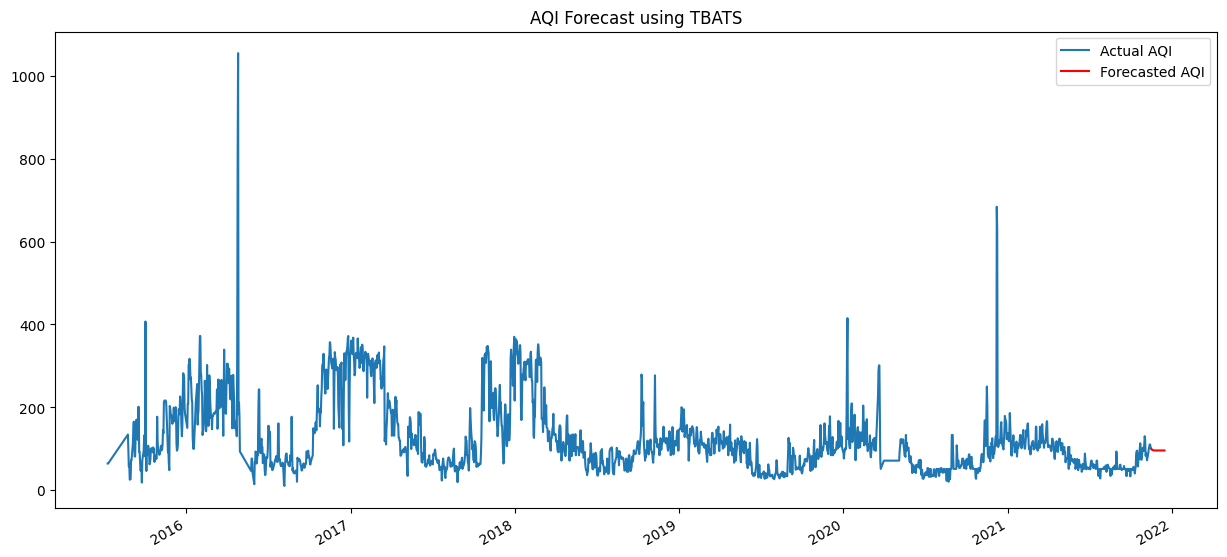

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
combined[:-30].plot(label='Actual AQI')
combined[-30:].plot(label='Forecasted AQI', color='red')
plt.legend(loc='best')
plt.title("AQI Forecast using TBATS")
plt.show()


In [ ]:
print("Forecasted AQI for the next 30 days:")
print(y_forecast)


Forecasted AQI for the next 30 days:
[98.92789537 97.55326285 96.76801635 96.29336936 96.00579258 95.83130822
 95.72534967 95.66097058 95.6218421  95.59805585 95.58359445 95.57480167
 95.56945527 95.56620434 95.56422755 95.56302551 95.56229457 95.56185011
 95.56157983 95.56141548 95.56131554 95.56125477 95.56121782 95.56119535
 95.56118168 95.56117337 95.56116832 95.56116525 95.56116338 95.56116224]


In [ ]:
forecasted_data = pd.Series(y_forecast, index=forecast_dates)
print(forecasted_data)


2021-11-16    98.927895
2021-11-17    97.553263
2021-11-18    96.768016
2021-11-19    96.293369
2021-11-20    96.005793
2021-11-21    95.831308
2021-11-22    95.725350
2021-11-23    95.660971
2021-11-24    95.621842
2021-11-25    95.598056
2021-11-26    95.583594
2021-11-27    95.574802
2021-11-28    95.569455
2021-11-29    95.566204
2021-11-30    95.564228
2021-12-01    95.563026
2021-12-02    95.562295
2021-12-03    95.561850
2021-12-04    95.561580
2021-12-05    95.561415
2021-12-06    95.561316
2021-12-07    95.561255
2021-12-08    95.561218
2021-12-09    95.561195
2021-12-10    95.561182
2021-12-11    95.561173
2021-12-12    95.561168
2021-12-13    95.561165
2021-12-14    95.561163
2021-12-15    95.561162
Freq: D, dtype: float64


In [ ]:
# Forecast for 365 days
y_forecast_365 = model.forecast(steps=365)


In [ ]:
forecast_dates_365 = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=365, freq='D')
forecast_series_365 = pd.Series(y_forecast_365, index=forecast_dates_365)

# Combining
combined_365 = data['AQI'].append(forecast_series_365, ignore_index=False)


<ipython-input-32-c9d39e5edf6a>:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_365 = data['AQI'].append(forecast_series_365, ignore_index=False)


In [ ]:
forecasted_data_365 = pd.Series(y_forecast_365, index=forecast_dates_365)
print(forecasted_data_365)


2021-11-16    98.927895
2021-11-17    97.553263
2021-11-18    96.768016
2021-11-19    96.293369
2021-11-20    96.005793
                ...    
2022-11-11    95.561160
2022-11-12    95.561160
2022-11-13    95.561160
2022-11-14    95.561160
2022-11-15    95.561160
Freq: D, Length: 365, dtype: float64


In [ ]:
train = data['AQI'][:-365]
test = data['AQI'][-365:]


In [ ]:
estimator = TBATS(seasonal_periods=(7, 365.25))
model_train = estimator.fit(train)


In [ ]:
y_pred = model_train.forecast(steps=365)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, y_pred)
mse = mean_squared_error(test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 41.96360870823356
Mean Squared Error (MSE): 3747.8479269573454
Root Mean Squared Error (RMSE): 61.21966944501861


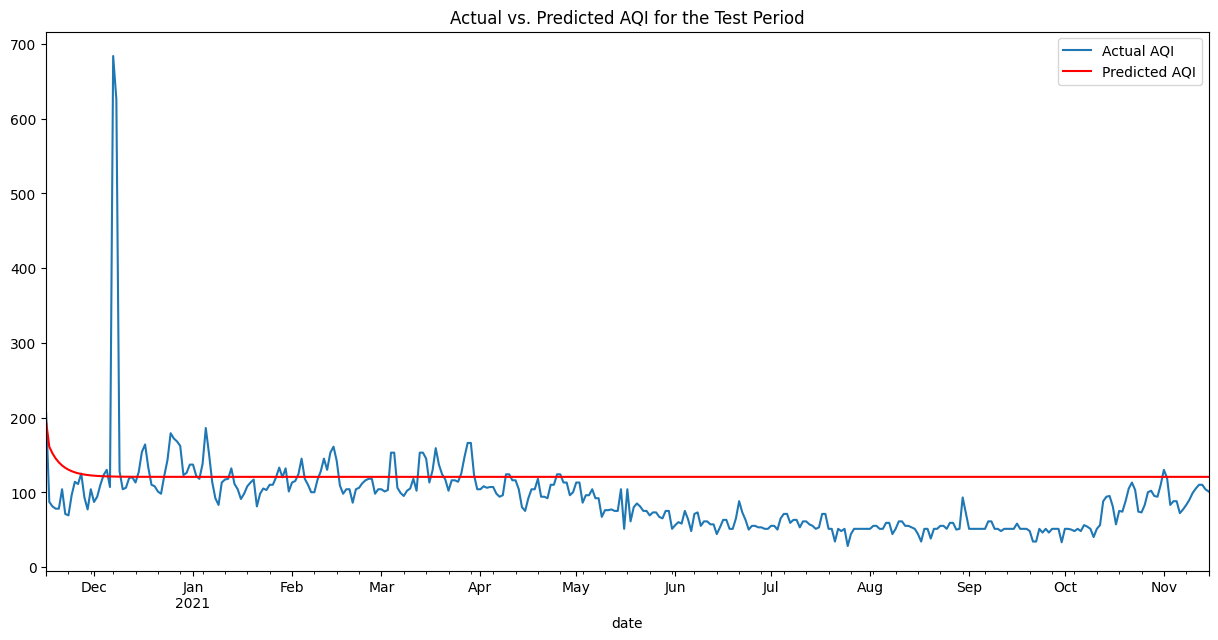

In [ ]:
plt.figure(figsize=(15, 7))
test.plot(label='Actual AQI')
pd.Series(y_pred, index=test.index).plot(label='Predicted AQI', color='red')
plt.legend(loc='best')
plt.title("Actual vs. Predicted AQI for the Test Period")
plt.show()


In [ ]:
# Define a full date range for the dataset
full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

# Reindex both training and test datasets
train = train.reindex(full_date_range).interpolate(method='time')
test = test.reindex(full_date_range).interpolate(method='time')


In [ ]:
!pip install pystan==2.19.1.1
!pip install fbprophet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp310-cp310-linux_x86_64.whl size=61973779 sha256=fb88305a4dc89ba0286f55ae23daf77bbfa8dc7e38e046ac2c02698b03dabe4e
  Stored in directory: /root/.cache/pip/wheels/3d/1c/94/4516243362eedbedad15ac4389691ee3bf2d45bec2639c9d8b
Successfully built pystan
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 51.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 76.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates 

In [ ]:
!pip uninstall --yes fbprophet
!pip install pystan==2.19.1.1
!pip install fbprophet


  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
Failed to build fbprophet
ERROR: Could not build wheels for fbprophet, which is required to install pyproject.toml-based projects


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import r2_score

# Fit the model
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365)
fit = model.fit()

# Forecast using the trained model for the period of the test set
y_pred = fit.forecast(steps=365)

# Calculate R^2 score
r2 = r2_score(test, y_pred)
accuracy_percentage = r2 * 100

print(f"R^2 Score: {r2:.4f}")
print(f"Accuracy in terms of percentage: {accuracy_percentage:.2f}%")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


R^2 Score: -62.1714
Accuracy in terms of percentage: -6217.14%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
!pip install keras tensorflow


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import numpy as np

# Convert time series to supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1):
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    df = pd.DataFrame(data)
    cols = []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    agg.dropna(inplace=True)
    return agg.values

# Normalize dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train.values.reshape(-1, 1))
scaled_test = scaler.transform(test.values.reshape(-1, 1))

# Convert data to supervised format
n_lag = 30
supervised_train = series_to_supervised(scaled_train, n_lag, 1)
X_train, y_train = supervised_train[:, :-1], supervised_train[:, -1]

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_lag, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
model.fit(X_train, y_train, epochs=50, verbose=0)

# Make predictions on the test set
predictions = []
history = list(scaled_train[-n_lag:])
for _ in range(len(scaled_test)):
    x_input = np.array(history[-n_lag:]).reshape(1, n_lag, 1)
    yhat = model.predict(x_input, verbose=0)
    predictions.append(yhat[0])
    history.append(scaled_test[_])

# Inverse transform predictions
predictions = scaler.inverse_transform(predictions)

# Calculate R^2 score
r2 = r2_score(test.values, predictions)
accuracy_percentage = r2 * 100

print(f"R^2 Score: {r2:.4f}")
print(f"Accuracy in terms of percentage: {accuracy_percentage:.2f}%")


R^2 Score: 0.5385
Accuracy in terms of percentage: 53.85%
